Welcome to the Notebook of this tutorial 

It is adapted using code from this paper:
https://arxiv.org/abs/2101.08093
and the MSc thesis of Lindsay Spoor: 
https://studenttheses.universiteitleiden.nl/handle/1887/3731859

## The Toric Game RL

#### Other resources for RL

The standard textbook on reinforcement learning is the one by Sutton & Bartho (http://incompleteideas.net/book/the-book-2nd.html -> Full PDF). It contains a lot of extra info. 

In [1]:
## Uncomment this to get data when you run on google colab:
#!git clone https://github.com/everthemore/QSC-2024.git

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
import os

from mwpm_calculator import get_MWPM_scores

In [2]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window

    return np.convolve(values, weights, "valid")


def plot_log_results(log_folder, learning_curve_path, error_rate, title="Average training reward"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")

    y = moving_average(y, window=100)

    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y, color = 'blue', linewidth=0.9)
    plt.yscale("linear")
    plt.xlabel("Number of training timesteps")
    plt.ylabel("Reward")
    plt.grid()
    plt.savefig(learning_curve_path+f'e_{error_rate}.jpg', dpi=300)

In [3]:

### Environment
class ToricGameEnv(gym.Env):
    ''' Bare minimum toric code environment. No rendering
    '''

    def __init__(self, size=5, error_rate=0.01, max_steps=100, render_mode=None):
        '''
        Args:
            size: board_size of the board to use
            error_rate: float, chance for a qubit to have an error
                if int, then this is a fixed number of errors
            max_steps: maximum number of allowed steps
        '''
        self.size = size
        self.error_rate = error_rate
        self.max_steps = max_steps
        self.render_mode = render_mode

        # Define action and observation space
        self.action_space = gym.spaces.Discrete(size*size*2)  
        self.observation_space = gym.spaces.MultiBinary(size*size)

        # Set some rewards
        self.reward_fail = -1
        self.reward_continue = 0
        self.reward_win = 1

        # Keep track of the moves
        self.qubit_flips = []
        self.initial_qubit_flips = []

        # Some usefull lists (these are static)
        self.qubit_pos   = [[x,y] for x in range(2*size) for y in range((x+1)%2, 2*size, 2)]
        self.plaquette_pos = [[x,y] for x in range(1,2*size,2) for y in range(1,2*size,2)]
        self.horizontal_boundary = [[0,x] for x in range(1, 2*size, 2)]
        self.vertical_boundary = [[y,0] for y in range(1, 2*size, 2)]


    def _get_obs(self):
        ''' Translates the environment state into an observation
        '''
        return self.operator_values
    

    def _get_related_plaqs(self, coord, return_values=False):
        ''' Find plaqs which neighbor the qubit at coord.
        '''
        plaqs = []
        if coord[0]%2 == 0:
            plaqs += [[(coord[0] + 1)%(2*self.size), coord[1]], 
                      [(coord[0] - 1)%(2*self.size), coord[1]]]
        else:
            plaqs += [[coord[0], (coord[1] + 1)%(2*self.size)], 
                      [coord[0], (coord[1] - 1)%(2*self.size)]]
            
        # Check if we should return the values
        if return_values:
            return [self.operator_values[self.plaquette_pos.index(plaq)] for plaq in plaqs]
        
        return plaqs


    def _flip_qubit(self, coord):
        ''' Flip a qubit at location coord, and update operator values

        Args:
            coord: [x,y] coordinate of qubit to flip
        '''
        # Flip the qubit
        qubit_index = self.qubit_pos.index(coord)
        self.qubit_values[qubit_index] = 1 - self.qubit_values[qubit_index]

        # Update syndrome positions
        plaqs = self._get_related_plaqs(coord)
        for plaq in plaqs:
            plaq_index = self.plaquette_pos.index(plaq)
            self.operator_values[plaq_index] = 1 - self.operator_values[plaq_index]

    
    def _has_logical_error(self):
        ''' Check if there is a logical error on the board.
            Assumes an empty board.
        '''
        errors = [0,0]

        # Check both boundaries for errors
        for pos in self.horizontal_boundary:
            qubit_index = self.qubit_pos.index(pos)
            errors[0] += self.qubit_values[qubit_index]

        for pos in self.vertical_boundary:
            qubit_index = self.qubit_pos.index(pos)
            errors[1] += self.qubit_values[qubit_index]

        # There's a logical error if the number on a boundary is odd
        if (errors[0]%2 == 1) or (errors[1]%2 == 1):
            return True

        return False
    

    def reset(self, seed=None, allow_empty=False, **kwargs):
        ''' Reset the environment.
        
        Args:
            allow_empty: if True, the board can be reset into an emtpy state with no errors
        '''
        super().reset(seed=seed)

        # Create a clean state
        self.terminated = False
        self.truncated = False
        self.total_steps = 0

        self.qubit_flips = []
        self.initial_qubit_flips = []
        self.qubit_values = np.zeros(2*self.size*self.size, dtype='int64')
        self.operator_values = np.zeros(self.size*self.size, dtype='int64')

        # If integer, generate fixed number of errors
        if np.issubdtype(type(self.error_rate), np.integer):
            flipped_qs = self.np_random.choice(np.arange(2*self.size*self.size), self.error_rate)
            for q_idx in flipped_qs:
                q = self.qubit_pos[q_idx]
                self.initial_qubit_flips.append(q)
                self._flip_qubit(q)
            return self._get_obs(), {'message': 'reset'}
        
        # For each qubit, try to flip according to the error rate
        assert self.error_rate > 0 and self.error_rate < 1
        for q in self.qubit_pos:
            if self.np_random.random() < self.error_rate:
                self.initial_qubit_flips.append(q)
                self._flip_qubit(q)
        
        # Check is board is empty, and if this is allowed
        if len(self.initial_qubit_flips) == 0:
            if not allow_empty:
                return self.reset()
            self.terminated = True

        return self._get_obs(), {'message': 'reset'}


    def step(self, action):
        ''' Flip a qubit number {action}

        action: int, number of qubit to flip [0, 2*size*size)
        '''
        self.total_steps += 1
        coord = self.qubit_pos[action]

        # Check if we generated an empty board
        if self.terminated:
            self.reward = self.reward_win
            message = 'success'
        
        # Check truncation
        elif self.total_steps > self.max_steps:
            self.reward = self.reward_fail
            self.truncated = True
            message = 'truncated'
        
        # Flip the qubit
        else:
            self.qubit_flips.append(action)
            self._flip_qubit(coord)

            # Check if state is terminal
            if np.sum(self.operator_values) == 0:
                self.terminated = True

                # Get the reward
                if self._has_logical_error():
                    self.reward = self.reward_fail
                    message = 'logical_error'
                else:
                    self.reward = self.reward_win
                    message = 'success'
            else:
                self.reward = self.reward_continue
                message = 'continue'

        return self._get_obs(), self.reward, self.terminated, self.truncated, {'message': message}
    
    def image_view(self, number=False, channel=0):
        image = np.empty((2*self.size, 2*self.size), dtype=object)

        for i, plaq in enumerate(self.plaquette_pos):
            if self.operator_values[i] == 1:
                image[plaq[0], plaq[1]] = "P"+str(i) if number else "P"
            elif self.operator_values[i] == 0:
                image[plaq[0], plaq[1]] = f"x{i:02}" if number else "x"
        for i,plaq in enumerate([[x,y] for x in range(0,2*self.size,2) for y in range(0,2*self.size,2)]):
            image[plaq[0], plaq[1]] = f"+{i:02}" if number else "+"

        for i,pos in enumerate(self.qubit_pos):
            image[pos[0], pos[1]] = f'{str(int(self.qubit_values[i]))}{i:02}' if number else str(int(self.qubit_values[i]))

        return np.array(image)
    
    def render(self, mode="human", close=False):
        fig, ax = plt.subplots()
        a=1/(2*self.size)

        for i, p in enumerate(self.plaquette_pos):
            if self.operator_values[i]==1:
                fc='darkorange'
                plaq = plt.Polygon([[a*p[0], a*(p[1]-1)], [a*(p[0]+1), a*(p[1])], [a*p[0], a*(p[1]+1)], [a*(p[0]-1), a*p[1]] ], fc=fc)
                ax.add_patch(plaq)
                
        # Draw lattice
        for x in range(self.size):
            for y in range(self.size):
                pos=(2*a*x, 2*a*y)
                width=a*2
                lattice = plt.Rectangle( pos, width, width, fc='none', ec='black' )
                ax.add_patch(lattice)


        for i, p in enumerate(self.qubit_pos):
            pos=(a*p[0], a*p[1])
            fc='darkgrey'
            if self.qubit_values[i] == 1 and self.qubit_values[i] == 0:
                fc='yellow'
            elif self.qubit_values[i] == 0 and self.qubit_values[i] == 1:
                fc='darkred'
            elif self.qubit_values[i] == 1 and self.qubit_values[i] == 1:
                fc='darkmagenta'
#            if len(self.qubits_flips[0])!=0 and i == self.qubits_flips[0][-1]:
#                fc='darkblue'
            circle = plt.Circle( pos , radius=a*0.25, ec='k', fc=fc)
            ax.add_patch(circle)
            plt.annotate(str(i), pos, fontsize=8, ha="center")

        ax.set_xlim([-.1,1.1])
        ax.set_ylim([-.1,1.1])
        ax.set_aspect(1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.axis('off')
        plt.show()


In [4]:
def train_agent(error, board_size, time_steps, n_evals, max_steps):
    log_dir = 'logs'

     # Create environment
    env = ToricGameEnv(error_rate=error, size=board_size, max_steps=max_steps)
    env = Monitor(env, filename=log_dir)

    # Train the model
    model = PPO("MlpPolicy", env, verbose=0)
    model.learn(total_timesteps=time_steps, progress_bar=True)
    model.save(log_dir+f'/model_at_e_{error}')

    # Simple evaluation loop
    env = env.unwrapped

    score = eval_pol(env, model, error, n_evals)

    # Plot and save the learning curve
    learning_curve_path = log_dir+'/learn_curve/'
    if not os.path.exists(learning_curve_path):
        os.makedirs(learning_curve_path)
    plot_log_results(log_dir, learning_curve_path, error)
    plt.show()

    return score

def eval_pol(env, model, err, n_evals):
    env.unwrapped.error_rate = err
    successes = 0
    for i_eval in range(n_evals):
        obs, info = env.reset(allow_empty=False)
        # Get actions untill board is empty
        done, truncated = False, False
        while not (done or truncated):
            action, _state = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)
        if info['message'] == 'success':
            successes += 1
    score = successes/n_evals
    return score

def watch_episode(env, model, err):
    env.unwrapped.error_rate = err
    obs, info = env.reset(allow_empty=False)
    env.render()
    # Get actions until board is empty
    done, truncated = False, False
    while not (done or truncated):
        action, _state = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        env.render()
    

In [5]:
err_range = np.linspace(0.01, 0.21, 3)
board_size = 3
time_steps = int(1e5)
n_evals = int(time_steps/10)
max_steps = 20

Output()

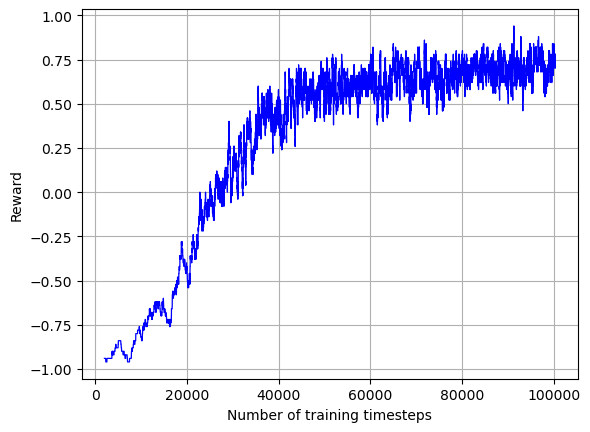

In [6]:
err = 0.05
score = train_agent(error=err, board_size = board_size, time_steps=time_steps, n_evals=n_evals, max_steps=max_steps)

Now let's train an agent for various error rates and compare it to another method, minimum weight perfect matching, and see how well our simple RL model performs. 

Output()

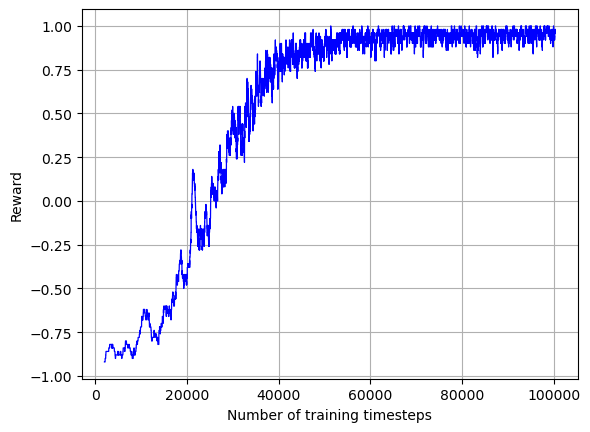

Output()

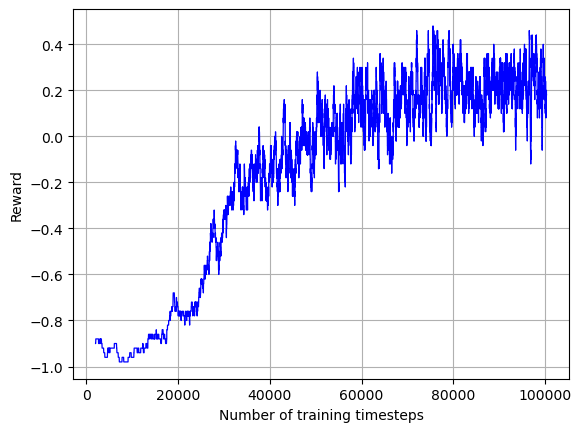

Output()

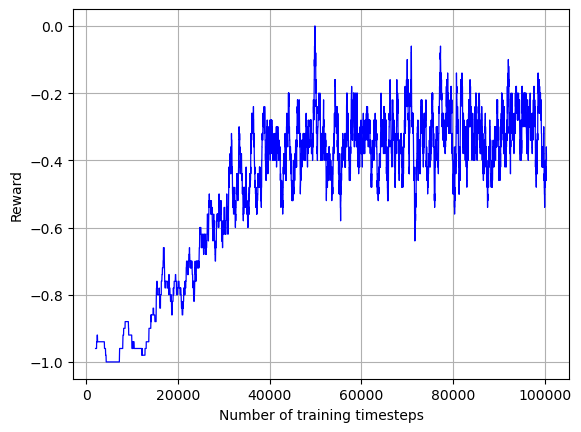

Simulating size=3...


<Figure size 640x480 with 0 Axes>

In [7]:
scores = []
for err in err_range:
    # getting the score of the RL agent
    score = train_agent(error=err, board_size = board_size, time_steps=time_steps, n_evals=n_evals, max_steps=max_steps)
    scores.append(score)

# getting the score of minimum weight perfect matching
mwpm_scores, mwpm_err = get_MWPM_scores(board_size, err_range, n_evals)

plt.plot(err_range, scores, '.-', label=f'PPO')
plt.plot(err_range, mwpm_scores, '.-', label='MWPM')
plt.xlabel('Physical error rate')
plt.ylabel('Success rate')
plt.grid(linestyle='dotted')
plt.legend()
plt.savefig('logs'+f'/performance.jpg', dpi=300)
plt.clf()


Now that we have trained an agent, we also watch what the agent does step by step for a fixed error rate. Just try it with the following block!

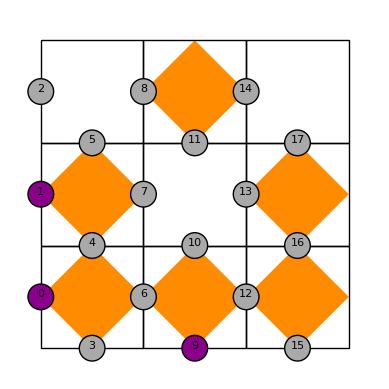

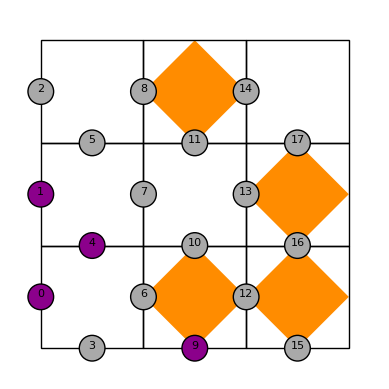

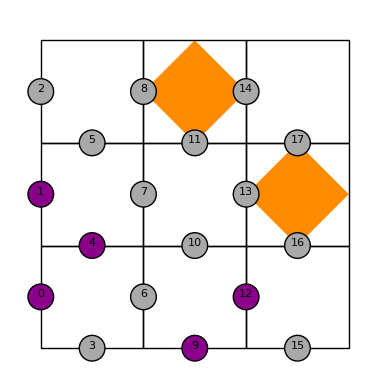

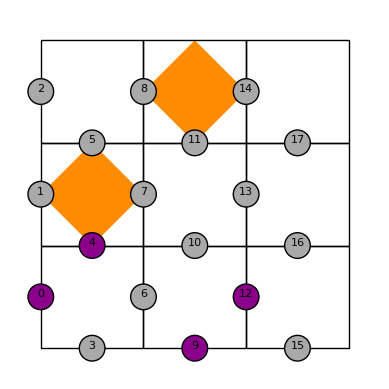

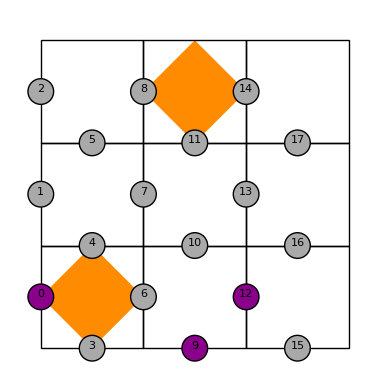

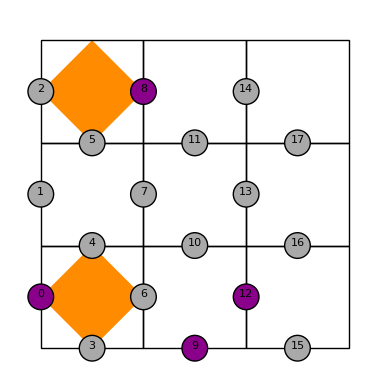

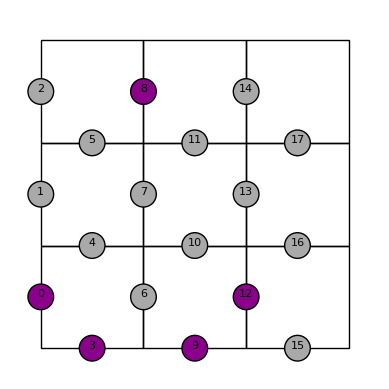

In [8]:
# watch a specific episode 
err = err_range[-1]
model = PPO.load('logs'+f'/model_at_e_{err}')
env = ToricGameEnv(error_rate=err, size=board_size, max_steps=20)
env = Monitor(env, filename='logs')
env = env.unwrapped
watch_episode(env, model, err)